In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw

from myPackage import cmdInput
import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()
from myPackage import evalOnLine


from meshGen import mesh2DLaminates

In [2]:
lambda1 = 1
lambda2 = 10

order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.05



modelHalfAir=False



## 1. Only Smooth
### 1.1. Reference Solution Only Smooth

In [4]:
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, onlySmooth=True, maxh_edges=maxh_edges*10, fullProblemX=True, rotated=True, modelHalfAir=modelHalfAir)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

maxh_edges [0.00125, 0.00125]
Boundaries {'right', 'itop', 'ibottom', 'bottom', 'top', 'left'}
Materials {'inner', 'insulation', 'outer'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

In [5]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="bottom|top")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * y/Norm(y), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 2.465260960555948     
CG iteration 2, residual = 1.0649970675358312e-14     


In [6]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( -grad(sol_ref)[1], meshRef, settings={"Objects":{"Wireframe":True}, "deformation": False})


energy:	0.6286962544621394


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 1.2 Multiscale only Smooth

In [7]:

cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="multiscale", onlySmooth=True,  maxh_edges=[maxh_edges, maxh_edges*10], rotated=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
Draw(meshMS.ngmesh)


from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)


maxh_edges [0.000125, 0.00125]
('outer', 'outer', 'multiscale')


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

In [22]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = True
cl_Phi.orientation = 1


force_full_Phi = True
moartaring = False
smoothB_fun_Fe = lambda x: 1e3 * lambda1/lambda2 * (x**2/cl_Phi.dFe * 1 - (cl_Phi.dFe/4 * 1))
smoothB_fun_0 = lambda x: 1e3*(-(x - (cl_Phi.d0/2+cl_Phi.dFe/2))**2/ cl_Phi.d0 * 1 + cl_Phi.d0/4 * 1)


smoothBPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smoothB_fun_Fe, smoothB_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothBPhi2", order="smB2", modelHalfAir=modelHalfAir)



def calcMultiscale(useGradients=True, drawPhis=True):

    smoothbnd = "itop|ibottom"
    # microshape functions

    domains = "multiscale"
    roughbnd = "left|right"
    orderPhi = [
            cl_Phi(0, fes_order=1, material=domains, dirichlet="top|bottom", useGradients=True, useAbsolutes=False), 
            cl_Phi(1, fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=False, useAbsolutes=True, modelHalfAir=True), 
            # cl_Phi([smoothBPhi2, smoothBPhi2.getDiff()], fes_order=order0, material=domains, dirichlet=roughbnd, useGradients=True, modelHalfAir=False),
            # cl_Phi(2, fes_order=order0, material=domains, dirichlet=roughbnd, inIron=False, modelHalfAir=False), 
        ]


    if not moartaring:
        orderPhi = orderPhi[1:]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi)
        cl_Phi.plotDirectEvaluated(orderPhi)



    VSpace = []
    # u0 
    domains_outer = "outer"
    if not moartaring:
        domains_outer += "|multiscale"
    VSpace.append(H1(meshMS, order=order0, dirichlet="top|bottom", definedon=meshMS.Materials(domains_outer))) 
    
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    gradgradMS = cl_gradgradMS(orderPhi, sol, addPhi0Outer=True)

    gradgradMS.generateCouplingMatrix(lambda2, lambda1, force_full_Phi=force_full_Phi)

    # for phi_a in cl_gradgradMS.coupling_matrix.keys():
    #     for phi_b in cl_gradgradMS.coupling_matrix[phi_a].keys():
    #         if (phi_a.order == 1 and phi_b.order == 2) or (phi_a.order == 2 and phi_b.order == 1):
    #             cl_gradgradMS.coupling_matrix[phi_a][phi_b] = 0



    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += lambda1  * grad(gradgradMS.trials[0]) * grad(gradgradMS.tests[0]) * dx("outer")
    a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu, gradgradMS.gradv, lambda2, lambda1, force_full_Phi=force_full_Phi) * dx("multiscale")

    alpha = 3.5
    h = specialcf.mesh_size

    u_start = 1 if moartaring else 0
    alpha = 3
    d_coupling = -d/2 if modelHalfAir else -d/2 + cl_Phi.d0/2


    # absolutes
    u_range = range(u_start, len(gradgradMS.u))
    # u_range = [1]
    um_bottom = sum(gradgradMS.u[i][0] * gradgradMS.u[i][1].DirectEvaluate(-d_coupling) for i in u_range)
    vm_bottom = sum(gradgradMS.v[i][0] * gradgradMS.v[i][1].DirectEvaluate(-d_coupling) for i in u_range)

    um_top = sum(gradgradMS.u[i][0] * gradgradMS.u[i][1].DirectEvaluate(d_coupling) for i in u_range)
    vm_top = sum(gradgradMS.v[i][0] * gradgradMS.v[i][1].DirectEvaluate(d_coupling) for i in u_range)

    jump_u_top = gradgradMS.u[0][0] - um_top
    jump_u_bottom = gradgradMS.u[0][0] - um_bottom

    jump_v_top = gradgradMS.v[0][0] - vm_top
    jump_v_bottom = gradgradMS.v[0][0] - vm_bottom

    # gradients
    grad_range = range(u_start, len(gradgradMS.gradu))
    # grad_range = [1] + list(range(4, len(gradgradMS.gradu)))
    
    gradum_bottom = sum(gradgradMS.gradu_trace_n[i][0] * gradgradMS.gradu_trace_n[i][1].DirectEvaluate(-d_coupling) for i in grad_range)
    gradvm_bottom = sum(gradgradMS.gradv_trace_n[i][0] * gradgradMS.gradv_trace_n[i][1].DirectEvaluate(-d_coupling) for i in grad_range)

    gradum_top = sum(gradgradMS.gradu_trace_n[i][0] * gradgradMS.gradu_trace_n[i][1].DirectEvaluate(d_coupling) for i in grad_range)
    gradvm_top = sum(gradgradMS.gradv_trace_n[i][0] * gradgradMS.gradv_trace_n[i][1].DirectEvaluate(d_coupling) for i in grad_range)

    jump_Bu_top = lambda1 * gradgradMS.gradu_trace_n[0][0] - lambda2 * gradum_top
    jump_Bu_bottom = lambda1 * gradgradMS.gradu_trace_n[0][0] - lambda2 * gradum_bottom

    jump_Bv_top = lambda1 * gradgradMS.gradv_trace_n[0][0] - lambda2 * gradvm_top
    jump_Bv_bottom = lambda1 * gradgradMS.gradv_trace_n[0][0] - lambda2 * gradvm_bottom

    # couple u
    if False:
        #[u][v]
        # a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u[u_start:], gradgradMS.v[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u[u_start:], gradgradMS.v[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u[:1], gradgradMS.v[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u[:1], gradgradMS.v[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        a += alpha*order0**2/h  * (jump_u_top)  * (jump_v_top)  *ds("itop")
        a += alpha*order0**2/h  * (jump_u_bottom)  * (jump_v_bottom)  *ds("ibottom")
        

    if False:
        #{dn u } [ v]
        # a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n[u_start:], gradgradMS.v[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n[u_start:], gradgradMS.v[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n[:1], gradgradMS.v[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n[:1], gradgradMS.v[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += (lambda2 * jump_gradu_top)  * (jump_v_top)  *ds("itop")
        a += (lambda2 * jump_gradu_bottom)  * (jump_v_bottom)  *ds("ibottom")


        #[ u] {dn v } 
        # a += -gradgradMS.getIntegrand4BFI(gradgradMS.u[u_start:], gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += gradgradMS.getIntegrand4BFI(gradgradMS.u[u_start:], gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += gradgradMS.getIntegrand4BFI(gradgradMS.u[:1], gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -gradgradMS.getIntegrand4BFI(gradgradMS.u[:1], gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += (lambda2 * jump_gradv_top)  * (jump_u_top)  *ds("itop")
        a += (lambda2 * jump_gradv_bottom)  * (jump_u_bottom)  *ds("ibottom")

    # couple fluxes
    if True:
        # [dn u] [ dn v]
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n[u_start:], gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n[u_start:], gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n[:1], gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n[:1], gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        # a += alpha*order0**2/h  * (jump_Bu_top)  * (jump_Bv_top)  *ds("itop")
        # a += alpha*order0**2/h  * (jump_Bu_bottom)  * (jump_Bv_bottom)  *ds("ibottom")


    # couple hesse 
    if False:

        #{gradgrad(u)_n_n } [ dn v]
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.hesse_u_trace_nn, gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.hesse_u_trace_nn, [gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI([gradgradMS.hesse_u_trace_nn[0]], gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI([gradgradMS.hesse_u_trace_nn[0]], [gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)


        #[ dn u] {gradgrad(v)_n_n } 
        a += -gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n, gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI([gradgradMS.gradu_trace_n[0]], gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n, [gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += -gradgradMS.getIntegrand4BFI([gradgradMS.gradu_trace_n[0]], [gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)

    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set(1 * y/Norm(y), BND)
    if moartaring:
        sol.components[1].Set(1 * y/Norm(y), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)

    print("anorm", a.mat.AsVector().Norm())

    energy =  Integrate(getIntegrand4BFI(gradgradMS.gradsol_pack, gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    return sol, gradgradMS.sol_pack, gradgradMS.sol_comp, gradgradMS.gradsol_comp, energy, gradgradMS

    




In [24]:
sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, gradgradMS = calcMultiscale(useGradients=False, drawPhis=False)

print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")
print(gradgradMS.ansatz)

unknown kewords:
dict_keys(['addPhi0Outer'])
CG iteration 1, residual = 2.9756070182020347     
CG iteration 2, residual = 3.0425127746949605e-14     
anorm 421445922.15414846
Norm soll diff 0.0007253398240433749 %
diff energy 0.6740055187384667 0.6286962544621394 0.04530926427632731 7.206860857647414 %
-grad(u0_outer) - u1 * grad(pyLobatto(1))


421445922.15414846

In [25]:
gradgradMS.printGradGradMatrix();

                      dx_v_pyPhiConstant    dy_v_pyPhiConstant             v_1
------------------  --------------------  --------------------  --------------
dx_u_pyPhiConstant                   7.3                   0       0
dy_u_pyPhiConstant                   0                     7.3  3600
u_1                                  0                  3600       2.81905e+06


In [26]:
gradgradMS.printCouplingMatrix();
assert gradgradMS.checkCouplingMatrxiSymmetric(1e-3) == True


                    0              1
--  --------------  -------------  --------------
                    pyPhiConstant  pydxLobatto(1)
0   pyPhiConstant   7.3            3600.0
1   pydxLobatto(1)  3600.0         2819047.619


In [27]:
print(sol_pack_MS[0][1].order)
i = 0
print(sol_pack_MS[i][1].name)
# Draw(sol_pack_MS[i][0], meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})

Draw(sum(sol_comp_MS), meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})

pyPhiConstant
pyPhiConstant


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 1.3 Comparison 

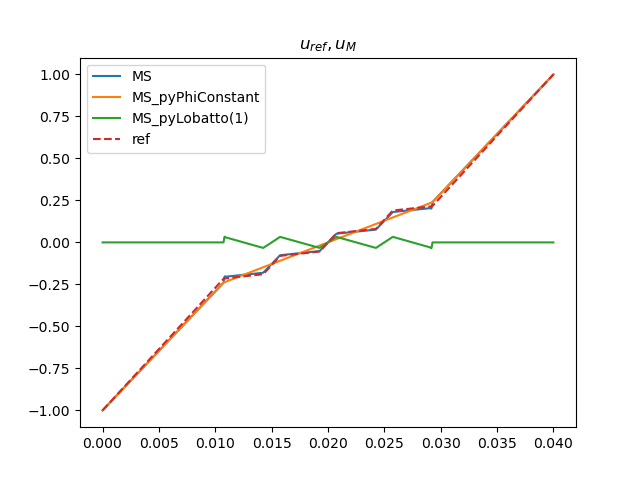

In [28]:


start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02


plt.figure(2)
start = -D/2
end = D/2



evalOnLine(sum(sol_comp_MS) , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="", clear=True, label="MS", show=False, N=1000);

[evalOnLine(sol_comp_MS[i] , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="", clear=False, label="MS_"+sol_pack_MS[i][1].name, show=False, N=1000) for i in range(len(sol_comp_MS))];
evalOnLine(sol_ref , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='--', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$u_{ref}, u_{M}$");


plt.legend()
plt.show()



In [29]:
energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                definedon=meshMS.Materials("multiscale"))

cl_gradgradMS.gradsol_pack[0][0]                                         

AttributeError: type object 'cl_gradgradMS' has no attribute 'gradsol_pack'

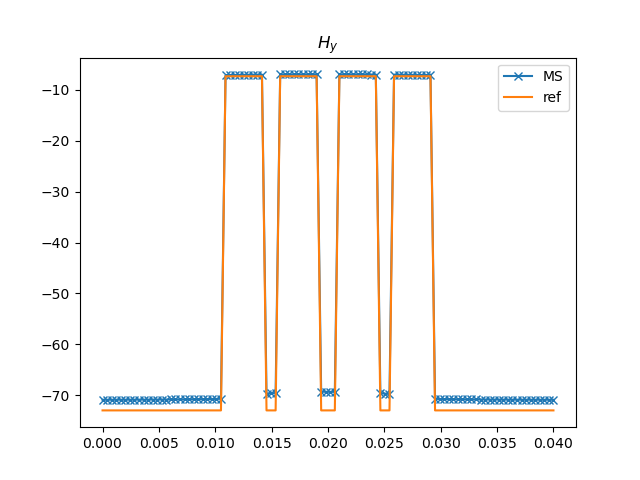

In [30]:
start = -D/2
end = D/2


plt.figure(3)
evalOnLine(sum(H_comp)[1] , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=100, title=r"$H_y$");
evalOnLine(-grad(sol_ref)[1] , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 100, title=r"$H_y$");


plt.legend()
plt.show()

In [31]:
print("Norm soll diff", Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print("L2, u_s")
[print("\t", sol_pack_MS[i][1].name, Integrate(sol_pack_MS[i][0] * sol_pack_MS[i][0], meshRef))for i in range(len(sol_pack_MS)) ]
print("L2, grad(u_s)")
[print("\t", gradgradMS.gradsol_pack[i][1].name, Integrate(gradgradMS.gradsol_pack[i][0] * gradgradMS.gradsol_pack[i][0], meshRef))for i in range(len(sol_pack_MS)) ]
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, f"{(energy_MS - energy_ref)/energy_ref * 100}%" )


Norm soll diff 7.216144651865147e-06
L2, u_s
	 pyPhiConstant 0.00019242749174555203
	 pyLobatto(1) 3.94975284806059e-07
L2, grad(u_s)
	 pyPhiConstant 2.4071212159975364
	 pydxLobatto(1) 3.94975284806059e-07
diff energy 0.6740055187384667 0.6286962544621394 0.04530926427632731 7.206860857647414%
